## Adding extrinsic noise to the synthetic datasets

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

fdir = '../data/'
out_fdir = '../plots/fig15/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

We also read in and normalize the experimentally determined energy matrix for the CRP activator (Kinney et al, 2010) (https://www.pnas.org/doi/full/10.1073/pnas.1004290107). The original energy matrix reported in the paper contains energy terms in the unit of $kcal / mol$, here we convert them to $k_BT$ units.

In [5]:
crp_emat_raw = pd.read_table(fdir + 'energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy() * 1.62
crp_emat = tregs.simulate.fix_wt(crp_emat, crp_site).T

### 1.1 Simple activation using the graph theory approach

We write the following functions to calculate the probability of the transcriptionally active states using the graph theory approach for a promoter with the simple activation regulatory architecture. In the `simact_graph` function, we allow breaking detailed balance at the E to P edge and at the P to AP edge.

In [6]:
def get_weight_gt(seq, energy_mat, e_wt=0):
    '''
    Computes the Boltzmann weight, exp(- d_energy / kBT). note that here
    d_energy is already in kBT units and so we don't have to perform the division.

    Args:
        seq (str): sequence of binding site
        energy_mat (arr): energy matrix
        e_wt (int, optional): total binding energy to the wild type binding
        site. Defaults to 0.

    Returns:
        float: Boltzmann weight.
    '''    

    d_energy = tregs.simulate.get_d_energy(seq, energy_mat, e_wt=e_wt)
    
    return np.exp(d_energy)


def simact_graph(p_seq, a_seq, c_p, c_a, p_emat, a_emat,
                 ep_wt, ea_wt, e_ap, U_P_unbinding, U_P_unbinding_with_A,
                 k_on=0.1, C_N=10**7):
    """
    Calculates the probability of RNAP being bound for a promoter with the
    simple activation architecture using the graph theory approach.

    Args:
        p_seq (str): Binding site sequence of the RNAP.
        a_seq (str): Binding site sequence of the activator.
        c_p (float): Concentration of the RNAP.
        c_a (float): Concentration of the activator.
        p_emat (np.array): Energy matrix for the RNAP.
        a_emat (np.array): Energy matrix for the activator.
        ep_wt (float): Wild-type binding energy for the RNAP.
        ea_wt (float): Wild-type binding energy for the activator.
        e_ap (float): Interaction energy between the activator and RNAP.
        U_P_unbinding (float): Unbinding energy of the RNAP when only RNAP is bound.
        U_P_unbinding_with_A (float): Unbinding energy of the RNAP when both RNAP and activator are bound.
        k_on (float, optional): Binding rate constant. Defaults to 0.1.
        C_N (float, optional): To molar concentration of non-specific binding sites. Defaults to 10**7.

    Returns:
        float: The probability of the transcriptionally active states (p_P + p_AP).
    """
    
    k_E_P = k_on
    k_E_A = k_on
    k_A_AP = k_on
    k_P_AP = k_on

    w_p = get_weight_gt(p_seq, p_emat, e_wt=ep_wt)
    w_a = get_weight_gt(a_seq, a_emat, e_wt=ea_wt)
    
    k_P_E = k_E_P * C_N * w_p * np.exp(U_P_unbinding)
    k_A_E = k_E_A * C_N * w_a
    k_AP_P = k_P_AP * C_N * w_a * np.exp(e_ap) 
    k_AP_A = k_A_AP * C_N * w_p * np.exp(e_ap) * np.exp(U_P_unbinding_with_A)

    # weights of each vertex
    rho_E = k_A_E * k_P_E * k_AP_P
    rho_E += k_A_AP * k_AP_P * k_P_E * c_p
    rho_E += k_P_E * k_AP_A * k_A_E
    rho_E += k_A_E * k_AP_A * k_P_AP * c_a

    rho_A = k_AP_P * k_P_E * k_E_A * c_a
    rho_A += k_E_P * k_P_AP * k_AP_A * c_a * c_p
    rho_A += k_P_E * k_E_A * k_AP_A * c_a
    rho_A += k_P_AP * k_AP_A * k_E_A * c_a**2

    rho_P = k_A_E * k_E_P * k_AP_P * c_p
    rho_P += k_E_P * k_A_AP * k_AP_P * c_p**2
    rho_P += k_AP_A * k_A_E * k_E_P * c_p
    rho_P += k_E_A * k_A_AP * k_AP_P * c_a * c_p

    rho_AP = k_A_E * k_E_P * k_P_AP * c_a * c_p
    rho_AP += k_E_P * k_P_AP * k_A_AP * c_a * c_p**2
    rho_AP += k_P_E * k_E_A * k_A_AP * c_a * c_p
    rho_AP += k_E_A * k_A_AP * k_P_AP * c_a**2 * c_p

    p_P = rho_P / (rho_A + rho_E + rho_P + rho_AP)
    p_AP = rho_AP / (rho_A + rho_E + rho_P + rho_AP)

    return p_P + p_AP

As a sanity check, we use the above function to simulate a synthetic dataset and plot the information footprint without breaking detailed balance by setting both `U_P_unbinding` and `U_P_unbinding_with_A` to 0.

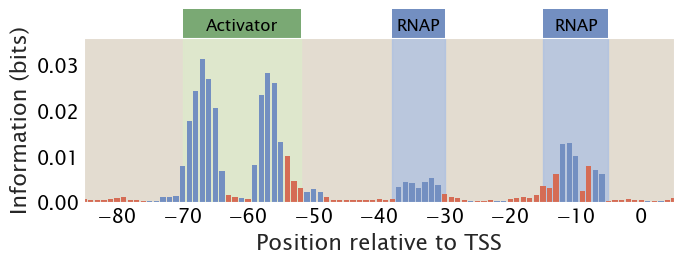

In [7]:
# copy numbers
c_p = 5000 # nM
c_a = 30 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -4

U_P_unbinding = 0
U_P_unbinding_with_A = 0

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap,
                          U_P_unbinding, U_P_unbinding_with_A])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact_graph.pdf')

As a point of comparison, we simulate a synthetic dataset and plot the information footprint using the canonical thermodynamic model with the same set of parameters.

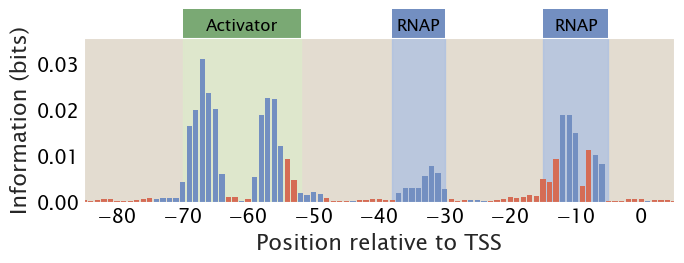

In [8]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
ea_wt = -13
e_ap = -4

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact.pdf')

### 1.2 Breaking detailed balance at the P to AP edge

Let's break detailed balance at the $k_\mathrm{AP, A}$ edge. Specifically, we let
$$
k_\mathrm{AP, A} = k_\mathrm{AP, A}^\mathrm{eq} * e^{\beta \Delta G},
$$
where $\Delta G$ measures the free energy invested to break detailed balance.

First, similar to what we did in the other notebooks, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand`.

In [10]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We simulate a set of synthetic datasets under a range of activator concentration and energies invested to break the detailed balance at the A to AP edge. We keep track of the average mutual information at the RNAP and activator binding sites.

In [12]:
c_p = 5000 # nM
ep_wt = -3
ea_wt = -13
e_ap = -4

l_c_a = 10 ** np.arange(-6, 6.1, 0.5) # nM
drive = np.arange(-40, 41, 5)

rnap_signal = []
act_signal = []

for U in drive:
    rnap_s = []
    act_s = []
    for c_a in l_c_a:
        rnap = []
        act = []
        for i in range(len(mutant_bank)):
            df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                                    *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap, 0, U],
                                    preset_mutants=mutant_bank[i],
                                    scaling_factor=10**6)

            mut_list = df['seq'].values
            mu_data = df['norm_ct_1']
            nbins = 2
            upper_bound = np.mean(mu_data)

            footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                        pseudocount=10**(-6))
            rnap_footprint = (np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2
            act_footprint = np.mean(footprint[(-70+115):(-52+116)])

            exshift = tregs.footprint.get_expression_shift(mut_list, mu_data, promoter)
            rnap_exshift = (np.mean(exshift[(-38+115):(-30+116)]) + np.mean(exshift[(-15+115):(-5+116)]))/2
            act_exshift = np.mean(exshift[(-70+115):(-52+116)])

            rnap_sign = 1 if rnap_exshift <= 0 else -1
            act_sign = 1 if act_exshift <= 0 else -1

            rnap.append(rnap_footprint * rnap_sign)
            act.append(act_footprint * act_sign)
        rnap_s.append(np.mean(rnap))
        act_s.append(np.mean(act))
    rnap_signal.append(rnap_s)
    act_signal.append(act_s)

rnap_signal = np.array(rnap_signal)
act_signal = np.array(act_signal)

The average mutual information at the RNAP and activator binding sites are plotted against activator concentration at different levels of energies invested to break detailed balance.

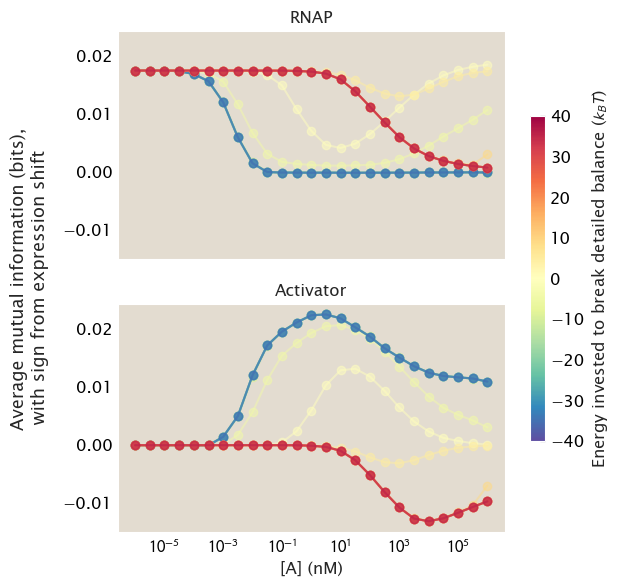

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6.5), sharey=True, sharex=True)

# Set up Seaborn palette and normalize colors
palette = sns.color_palette("Spectral_r", n_colors=len(drive))
cmap = sns.color_palette("Spectral_r", as_cmap=True)
norm = plt.Normalize(min(drive), max(drive))

zorder = np.concatenate((np.arange(10, 1, -1), np.arange(13, 21, 1)))

for i,d in enumerate(drive):
    rnap_s = rnap_signal[i]
    act_s = act_signal[i]
    axes[0].plot(l_c_a, rnap_s, 'o-', color=palette[i], zorder=zorder[i], alpha=0.5)
    axes[1].plot(l_c_a, act_s, 'o-', color=palette[i], zorder=zorder[i], alpha=0.5)

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Customize the placement of the colorbar
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Energy invested to break detailed balance ($k_BT$)')

# Setting custom ticks for log scale
tick_positions = [10**-5, 10**-3, 10**-1, 10**1, 10**3, 10**5]
tick_labels = ['$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$10^1$', '$10^3$', '$10^5$']

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels(tick_labels)
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels)

axes[1].set_xlabel('[A] (nM)')
axes[0].set_title('RNAP', fontsize=12)
axes[1].set_title('Activator', fontsize=12)

# Add a big central Y axis label
fig.text(-0.09, 0.5, 'Average mutual information (bits),\n with sign from expression shift',
         va='center', rotation='vertical', fontsize=13)

plt.savefig('../plots/fig15/simact_graph_mutants.pdf', bbox_inches='tight')
plt.show()

### 1.3 Example footprints with broken detailed balance

Information footprint where an energy of 40 $k_BT$ (2  ATPs) is invested to break detailed balance at the A to AP edge.

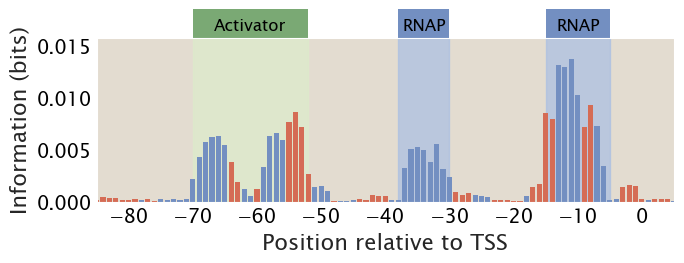

In [19]:
# copy numbers
c_a = 0.003 # nM
c_p = 5000 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -4

U_P_unbinding = 0
U_P_unbinding_with_A = -40

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap,
                          U_P_unbinding, U_P_unbinding_with_A])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact_graph_broken1.pdf')

Information footprint where a positive energy of 40 $k_BT$ (2 ATPs) is invested to break detailed balance at the AP -> A edge.

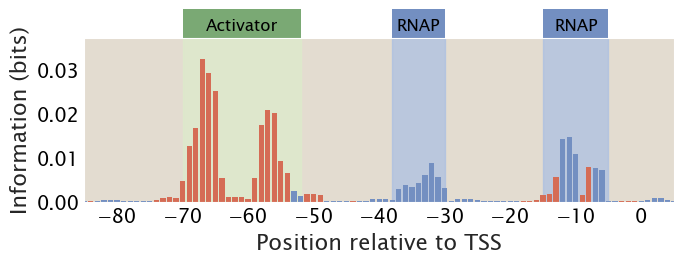

In [16]:
# copy numbers
c_a = 10**3 # nM
c_p = 5000 # nM

# binding energies
ep_wt = -3
ea_wt = -13
e_ap = -4

U_P_unbinding = 0
U_P_unbinding_with_A = 40

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap,
                          U_P_unbinding, U_P_unbinding_with_A],
                          scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=7,
                               outfile='../plots/fig15/simact_graph_broken2.pdf')